<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6
### <center> Beating benchmarks in "How good is your Medium article?"
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline". Do not forget about our shared ["primitive" baseline](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_english/topic04_linear_models/kaggle_medium_ridge_baseline.ipynb) - you'll find something valuable there.

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
import pickle
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit

In [2]:
PATH_TO_DATA = '../../../mlco_data/medium'

The following code will help to throw away all HTML tags from an article content.

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [4]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [5]:
def preprocess_to_txt(path_to_inp_json_file, path_to_out_txt_file):
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
        open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')

In [6]:
def preprocess_to_list(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [7]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA,'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [8]:
submission = pd.read_csv(os.path.join(PATH_TO_DATA,'sample_submission.csv'), index_col='id')

In [9]:
submission['log_recommends'] = 0
submission.to_csv('0_submission.csv')

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [10]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            feature_files[0].write(content_no_html_tags + '\n')
            
            published = json_data['published']
            feature_files[1].write(str(published) + '\n')
            
            title = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            feature_files[2].write(title + '\n')
            
            author = json_data['author']
            feature_files[3].write(str(author) + '\n')

In [5]:
feature_file = open(os.path.join(PATH_TO_DATA,'train_link_tags.txt'),'w', encoding='utf-8')

with open(os.path.join(PATH_TO_DATA, 'train.json'), 
              encoding='utf-8') as inp_json_file:

    for line in tqdm_notebook(inp_json_file):
        json_data = read_json_line(line)
        content = json_data['link_tags']
        #content_no_html_tags = strip_tags(content)
        feature_file.write(str(content) + '\n')

A Jupyter Widget

In [6]:
feature_file = open(os.path.join(PATH_TO_DATA,'test_link_tags.txt'),'w', encoding='utf-8')

with open(os.path.join(PATH_TO_DATA, 'test.json'), 
              encoding='utf-8') as inp_json_file:

    for line in tqdm_notebook(inp_json_file):
        json_data = read_json_line(line)
        content = json_data['meta_tags']
        #content_no_html_tags = strip_tags(content)
        feature_file.write(str(content) + '\n')

A Jupyter Widget

In [9]:
link_tags = pd.read_table(os.path.join(PATH_TO_DATA,'train_link_tags.txt'), sep='\n', header=None).applymap(lambda x: eval(x))

In [14]:
link_tags[0][666]

{'alternate': 'android-app://com.medium.reader/https/medium.com/p/5bafc01c8714',
 'apple-touch-icon': 'https://cdn-images-1.medium.com/fit/c/120/120/1*fQemuGcyRQM3ZhWjxEttbQ@2x.png',
 'author': 'https://medium.com/@Dr_Tabor',
 'canonical': 'https://medium.com/boosted/the-brief-history-of-hashimotos-treatment-5bafc01c8714',
 'icon': 'https://cdn-static-1.medium.com/_/fp/icons/favicon-rebrand-medium.3Y6xpZ-0FSdWDnPM3hSBIA.ico',
 'mask-icon': 'https://cdn-static-1.medium.com/_/fp/icons/monogram-mask.KPLCSFEZviQN0jQ7veN2RQ.svg',
 'publisher': 'https://plus.google.com/103654360130207659246',
 'search': '/osd.xml',
 'stylesheet': 'https://cdn-static-1.medium.com/_/fp/css/main-branding-base.dHv3MHpy06pRs4706uR7tg.css'}

In [12]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

A Jupyter Widget

In [9]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

A Jupyter Widget

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [3]:
chunks=pd.read_table(os.path.join(PATH_TO_DATA,'train_html.txt'), sep='\n', header=None, chunksize=1000)

In [4]:
train_html = pd.DataFrame()
train_html = pd.concat(chunk for chunk in chunks)

In [5]:
chunks = pd.read_table(os.path.join(PATH_TO_DATA,'test_html.txt'), sep='\n', header=None, chunksize=1000)

In [6]:
test_html = pd.DataFrame()
test_html = pd.concat(chunk for chunk in chunks)

In [7]:
train_html.shape, test_html.shape

((62313, 1), (34645, 1))

In [8]:
train_html['num_pics'] = train_html.applymap(lambda x: x.count('<img'))

In [9]:
test_html['num_pics'] = test_html.applymap(lambda x: x.count('<img'))

In [10]:
test_html.head(3)

,0,num_pics
0,"<div><header class=""container u-maxWidth740""><...",11
1,"<div><header class=""container u-maxWidth740""><...",6
2,"<div><header class=""container u-maxWidth740""><...",4


In [53]:
train_html['num_pics_bins'] = pd.cut(train_html['num_pics'], bins=(3,4,5,6,9,10,12,17,534))

In [54]:
train_html['num_pics_bins'].value_counts()

(6, 9]       12593
(3, 4]       10267
(4, 5]        6263
(5, 6]        5531
(12, 17]      4866
(17, 534]     4510
(10, 12]      3946
(9, 10]       2647
Name: num_pics_bins, dtype: int64

In [55]:
test_html['num_pics_bins'] = pd.cut(test_html['num_pics'], bins=(3,4,5,6,9,10,12,17,534))

In [56]:
test_html['num_pics_bins'].value_counts()

(6, 9]       7029
(3, 4]       6405
(4, 5]       4103
(5, 6]       3546
(12, 17]     2490
(17, 534]    2120
(10, 12]     1974
(9, 10]      1380
Name: num_pics_bins, dtype: int64

In [60]:
X_train_pics = pd.DataFrame(pd.get_dummies(train_html['num_pics_bins'],prefix='pics'))

X_test_pics = pd.DataFrame(pd.get_dummies(test_html['num_pics_bins'],prefix='pics'))

In [62]:
X_test_pics.head()

,"pics_(3, 4]","pics_(4, 5]","pics_(5, 6]","pics_(6, 9]","pics_(9, 10]","pics_(10, 12]","pics_(12, 17]","pics_(17, 534]"
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0


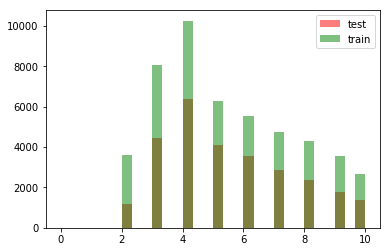

In [30]:
plt.hist(test_html['num_pics'], bins=30, alpha=.5, color='red', label='test', range=(0,10));
plt.hist(train_html['num_pics'], bins=30, alpha=.5, color='green', label='train', range=(0,10));
plt.legend();

In [31]:
from scipy import stats

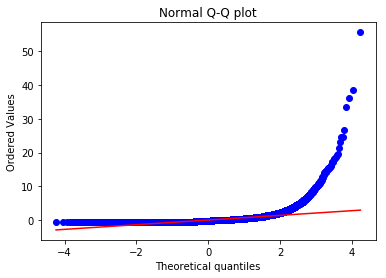

In [32]:
z = (train_html['num_pics'] - np.mean(train_html['num_pics']))/np.std(train_html['num_pics'])
stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [36]:
train_html['num_pics_log'] = train_html['num_pics'].apply(lambda x: np.log(x))
test_html['num_pics_log'] = test_html['num_pics'].apply(lambda x: np.log(x))

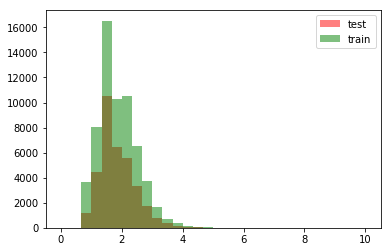

In [37]:
plt.hist(test_html['num_pics_log'], bins=30, alpha=.5, color='red', label='test', range=(0,10));
plt.hist(train_html['num_pics_log'], bins=30, alpha=.5, color='green', label='train', range=(0,10));
plt.legend();

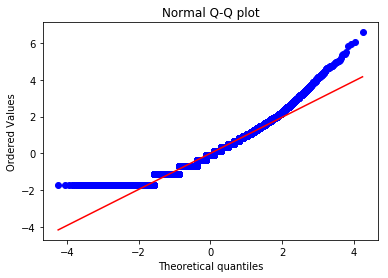

In [38]:
z = (train_html['num_pics_log'] - np.mean(train_html['num_pics_log']))/np.std(train_html['num_pics_log'])
stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [16]:
train_tags = pd.read_table(os.path.join(PATH_TO_DATA,'train_tags.txt'), sep='\n', header=None)
test_tags = pd.read_table(os.path.join(PATH_TO_DATA,'test_tags.txt'), sep='\n', header=None)
train_tags.shape, test_tags.shape

((62313, 1), (32772, 1))

In [20]:
train_tags[0].value_counts()

[]    62313
Name: 0, dtype: int64

***Tf-Idf with article content ***

In [4]:
train_content = pd.read_table(os.path.join(PATH_TO_DATA,'train_content.txt'), sep='\n', header=None)
test_content = pd.read_table(os.path.join(PATH_TO_DATA,'test_content.txt'), sep='\n', header=None)

In [5]:
train_content.shape, test_content.shape

((62313, 1), (34645, 1))

In [6]:
train_content['num_words'] = train_content.applymap(lambda x: len(x.split()))

In [7]:
test_content['num_words'] = test_content.applymap(lambda x: len(x.split()))

In [8]:
train_content['num_words_log'] = train_content['num_words'].apply(lambda x: np.log(x))
test_content['num_words_log'] = test_content['num_words'].apply(lambda x: np.log(x))

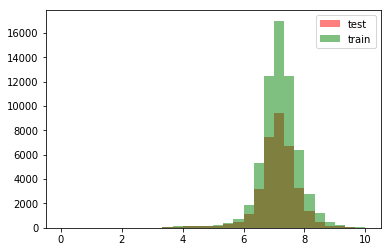

In [9]:
plt.hist(test_content['num_words_log'], bins=30, alpha=.5, color='red', label='test', range=(0,10));
plt.hist(train_content['num_words_log'], bins=30, alpha=.5, color='green', label='train', range=(0,10));
plt.legend();

In [228]:
%%time
cv = CountVectorizer(max_features=50000)
X_train_content_sparse = cv.fit_transform(train_content[0])

CPU times: user 1min 49s, sys: 2.83 s, total: 1min 51s
Wall time: 1min 51s


In [229]:
%%time
X_test_content_sparse = cv.transform(test_content[0])

CPU times: user 51.5 s, sys: 388 ms, total: 51.9 s
Wall time: 51.9 s


In [230]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 50000), (34645, 50000))

In [16]:
with open(os.path.join(PATH_TO_DATA, 'X_train_content_sparse.pkl'), 'wb') as X_train_pkl:
    pickle.dump(X_train_content_sparse, X_train_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_content_sparse.pkl'), 'wb') as X_test_pkl:
    pickle.dump(X_test_content_sparse, X_test_pkl, protocol=2)

In [318]:
%%time
cv = CountVectorizer(max_features=50000)
X_train_content_sparse_short = cv.fit_transform(train_content[idx][0])

CPU times: user 1min 38s, sys: 2.63 s, total: 1min 41s
Wall time: 1min 41s


In [320]:
%%time
X_test_content_sparse_short = cv.transform(test_content[0])

CPU times: user 49.5 s, sys: 376 ms, total: 49.9 s
Wall time: 49.8 s


***Tf-Idf with article titles***

In [396]:
train_title = pd.read_table(os.path.join(PATH_TO_DATA,'train_title.txt'), sep='\n', header=None)
test_title = pd.read_table(os.path.join(PATH_TO_DATA,'test_title.txt'), sep='\n', header=None)

In [397]:
train_content.shape, test_content.shape

((62313, 3), (34645, 3))

In [398]:
%%time
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=100000)
X_train_title_sparse = tfidf.fit_transform(train_title[0])

CPU times: user 3.45 s, sys: 56.1 ms, total: 3.51 s
Wall time: 3.5 s


In [399]:
%%time
X_test_title_sparse = tfidf.transform(test_title[0])

CPU times: user 811 ms, sys: 0 ns, total: 811 ms
Wall time: 809 ms


In [400]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

In [22]:
with open(os.path.join(PATH_TO_DATA, 'X_train_title_sparse.pkl'), 'wb') as X_train_pkl:
    pickle.dump(X_train_title_sparse, X_train_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_title_sparse.pkl'), 'wb') as X_test_pkl:
    pickle.dump(X_test_title_sparse, X_test_pkl, protocol=2)

***Bag of authors (i.e. One-Hot-Encoded author names)***

In [231]:
%%time
train_author = pd.read_table(os.path.join(PATH_TO_DATA,'train_author.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

test_author = pd.read_table(os.path.join(PATH_TO_DATA,'test_author.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

CPU times: user 2.41 s, sys: 3.88 ms, total: 2.42 s
Wall time: 2.41 s


In [232]:
train_author.shape, test_author.shape

((62313, 1), (34645, 1))

In [233]:
train_author.head()

,0
0,"{'name': None, 'url': 'https://medium.com/@Med..."
1,"{'name': None, 'url': 'https://medium.com/@Med..."
2,"{'name': None, 'url': 'https://medium.com/@ael..."
3,"{'name': None, 'url': 'https://medium.com/@vai..."
4,"{'name': None, 'url': 'https://medium.com/@vai..."


In [234]:
%%time
train_author['twitter'] = train_author.iloc[:, 0].apply(lambda x: x.get('twitter'))
train_author['url'] = train_author.iloc[:, 0].apply(lambda x: x.get('url'))
train_author['name'] = train_author.iloc[:, 0].apply(lambda x: x.get('name'))

test_author['twitter'] = test_author.iloc[:, 0].apply(lambda x: x.get('twitter'))
test_author['url'] = test_author.iloc[:, 0].apply(lambda x: x.get('url'))
test_author['name'] = test_author.iloc[:, 0].apply(lambda x: x.get('name'))

CPU times: user 95.4 ms, sys: 0 ns, total: 95.4 ms
Wall time: 93.7 ms


In [235]:
train_author['name'] = train_author['name'].map(str)
train_author['url'] = train_author['url'].map(str)
train_author['twitter'] = train_author['twitter'].map(str)

test_author['name'] = test_author['name'].map(str)
test_author['url'] = test_author['url'].map(str)
test_author['twitter'] = test_author['twitter'].map(str)

In [236]:
train_author.head()

,0,twitter,url,name
0,"{'name': None, 'url': 'https://medium.com/@Med...",@Medium,https://medium.com/@Medium,None
1,"{'name': None, 'url': 'https://medium.com/@Med...",@Medium,https://medium.com/@Medium,None
2,"{'name': None, 'url': 'https://medium.com/@ael...",@aelcenganda,https://medium.com/@aelcenganda,None
3,"{'name': None, 'url': 'https://medium.com/@vai...",@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None
4,"{'name': None, 'url': 'https://medium.com/@vai...",@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None


In [237]:
train_author.drop(0, axis=1, inplace=True)
test_author.drop(0, axis=1, inplace=True)

In [238]:
train_author.head()

,twitter,url,name
0,@Medium,https://medium.com/@Medium,None
1,@Medium,https://medium.com/@Medium,None
2,@aelcenganda,https://medium.com/@aelcenganda,None
3,@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None
4,@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None


In [239]:
len(set(train_author['twitter'].values)), len(set(test_author['twitter'].values))

(23588, 12199)

In [16]:
df = np.array(([1,2,3],[1,1,3], [1,2,2], [1,2,1], [1,2,3]))

In [17]:
df = pd.DataFrame(df)

In [18]:
df

,0,1,2
0,1,2,3
1,1,1,3
2,1,2,2
3,1,2,1
4,1,2,3


In [19]:
encoder = LabelBinarizer(sparse_output=False)
encoded = encoder.fit_transform(df[2])

In [20]:
encoded

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [240]:
encoder = LabelBinarizer(sparse_output=True)
X_test_author_sparse = encoder.fit_transform(test_author['twitter'])

In [241]:
encoder.inverse_transform(X_test_author_sparse[6,:])

array(['None'],
      dtype='<U16')

In [242]:
X_train_author_sparse = encoder.transform(train_author['twitter'])

In [243]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 12199), (34645, 12199))

In [244]:
len(set(train_author['twitter'].values).intersection(set(test_author['twitter'].values)))

4588

**Clipped version of author**

In [245]:
idx = train_published['year']>2014

In [246]:
train_author_short = train_author[idx]

In [247]:
X_train_author_sparse_short = encoder.transform(train_author_short['twitter'])

In [248]:
X_train_author_sparse.shape, X_train_author_sparse_short.shape

((62313, 12199), (57125, 12199))

*** Time features***

In [207]:
train_published = pd.read_table(os.path.join(PATH_TO_DATA,'train_published.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

test_published = pd.read_table(os.path.join(PATH_TO_DATA,'test_published.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

In [208]:
train_published['published'] = train_published.iloc[:, 0].apply(lambda x: x.get('$date'))
train_published['published'] = train_published['published'].apply(pd.to_datetime).fillna(method='ffill')

test_published['published'] = test_published.iloc[:, 0].apply(lambda x: x.get('$date'))
test_published['published'] = test_published['published'].apply(pd.to_datetime).fillna(method='ffill')

In [209]:
train_published['year'] = train_published['published'].apply(lambda ts: ts.year)
train_published['month'] = train_published['published'].apply(lambda ts: ts.month)
train_published['weekday'] = train_published['published'].apply(lambda ts: ts.weekday())

test_published['year'] = test_published['published'].apply(lambda ts: ts.year)
test_published['month'] = test_published['published'].apply(lambda ts: ts.month)
test_published['weekday'] = test_published['published'].apply(lambda ts: ts.weekday())

In [210]:
train_published['year_month'] = train_published['year']*100 + train_published['month']
test_published['year_month'] = test_published['year']*100 + test_published['month']

In [211]:
scaler = StandardScaler()
scaler.fit(train_published['year_month'].values.reshape(-1,1))

train_published['year_month_scaled'] = scaler.transform(train_published['year_month'].values.reshape(-1,1))
test_published['year_month_scaled'] = scaler.transform(test_published['year_month'].values.reshape(-1,1))

/home/kcostya/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [212]:
test_published.head()

,0,published,year,month,weekday,year_month,year_month_scaled
0,{'$date': '2018-02-21T17:01:00.928Z'},2018-02-21 17:01:00.928,2018,2,2,201802,1.921747
1,{'$date': '2017-12-07T15:56:00.967Z'},2017-12-07 15:56:00.967,2017,12,3,201712,1.056774
2,{'$date': '2018-02-08T17:33:27.816Z'},2018-02-08 17:33:27.816,2018,2,3,201802,1.921747
3,{'$date': '2018-02-09T18:04:12.262Z'},2018-02-09 18:04:12.262,2018,2,4,201802,1.921747
4,{'$date': '2017-10-02T23:08:00.000Z'},2017-10-02 23:08:00.000,2017,10,0,201710,1.037553


In [213]:
train_published.drop([0,'published'], axis=1, inplace=True)
test_published.drop([0,'published'], axis=1, inplace=True)

In [214]:
train_published.head()

,year,month,weekday,year_month,year_month_scaled
0,2012,8,0,201208,-3.787076
1,2015,8,0,201508,-0.903832
2,2017,2,6,201702,0.960666
3,2017,5,5,201705,0.989499
4,2017,6,6,201706,0.999109


In [401]:
X_train_time_features = pd.DataFrame(pd.concat([train_published['year_month_scaled'],
                                                pd.get_dummies(train_published['weekday'],prefix='day')], axis=1))

X_test_time_features = pd.DataFrame(pd.concat([test_published['year_month_scaled'],
                                               pd.get_dummies(test_published['weekday'],prefix='day')], axis=1))

In [402]:
X_train_time_features.columns

Index(['year_month_scaled', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')

In [403]:
X_train_time_features.head()

,year_month_scaled,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,-3.787076,1,0,0,0,0,0,0
1,-0.903832,1,0,0,0,0,0,0
2,0.960666,0,0,0,0,0,0,1
3,0.989499,0,0,0,0,0,1,0
4,0.999109,0,0,0,0,0,0,1


In [366]:
X_train_time_features.drop(['day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'], axis=1, inplace=True)

In [368]:
X_test_time_features.drop(['day_0', 'day_1', 'day_2', 'day_3', 'day_4',
      'day_5', 'day_6'], axis=1, inplace=True)

In [369]:
X_train_time_features.shape, X_test_time_features.shape

((62313, 1), (34645, 1))

In [370]:
X_train_time_features[idx].shape

(57125, 1)

In [371]:
train_published['year'].value_counts()

2016    25120
2017    20818
2015    11187
2014     3940
2013     1078
2012       96
2011       36
2010       10
2009        8
2008        8
1970        3
2007        3
2006        2
2005        1
2004        1
2003        1
1987        1
Name: year, dtype: int64

In [405]:
X_train_time_features_short = X_train_time_features[idx]
X_train_time_features_short.shape

(57125, 8)

**Join all sparse matrices.**

In [410]:
X_train

(34645, 50000)

In [414]:
%%time
X_train_sparse = csr_matrix(hstack([X_train_content_sparse_short, X_train_author_sparse_short, #X_train_title_sparse_short
                                    #X_train_time_features_short,
                                    train_content[['num_words_log']][idx]]))

X_test_sparse = csr_matrix(hstack([X_test_content_sparse_short, X_test_author_sparse, #X_test_title_sparse, 
                                   #X_test_time_features, 
                                   test_content[['num_words_log']]]))

CPU times: user 19.5 s, sys: 3.24 s, total: 22.8 s
Wall time: 22.8 s


In [416]:
X_train_sparse.shape, X_test_sparse.shape

((57125, 62200), (34645, 62200))

**Read train target and split data for validation.**

In [417]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA,'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values
y_train = y_train[idx]

In [418]:
train_part_size = int(0.5 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [378]:
train_target.head()

,log_recommends
id,
8,9.01201
14,3.49651
19,0.69315
22,1.38629
29,1.94591


In [379]:
ridge = Ridge(random_state=17, alpha=0.1)

In [380]:
%%time
ridge.fit(X_train_part_sparse, y_train_part);

CPU times: user 3min 18s, sys: 448 ms, total: 3min 19s
Wall time: 3min 19s


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [381]:
ridge_pred = ridge.predict(X_valid_sparse)

In [382]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.2992639985925754, 2.6665970536893084)

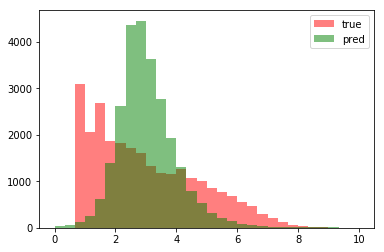

In [383]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [419]:
ridge = Ridge(random_state=17, alpha=0.1)

In [420]:
%%time
ridge.fit(X_train_sparse, y_train);

CPU times: user 5min 52s, sys: 780 ms, total: 5min 53s
Wall time: 5min 53s


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [421]:
X_train_sparse.shape

(57125, 62200)

In [422]:
%%time
ridge_test_pred = ridge.predict(X_test_sparse)

CPU times: user 83.9 ms, sys: 0 ns, total: 83.9 ms
Wall time: 83 ms


In [423]:
write_submission_file(ridge_test_pred, 'assignment6_medium_submission_62208_a1e-1_short.csv')

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [424]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      'medium_all_zeros_submission.csv')

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [425]:
sum(ridge_test_pred), 4.33328*ridge_test_pred.shape[0]

(107618.45455143359, 150126.4856)

In [426]:
modifier = (4.33328*ridge_test_pred.shape[0])/sum(ridge_test_pred)
modifier

1.394988305915978

In [427]:
ridge_test_pred_modif = ridge_test_pred*modifier

In [428]:
ridge_test_pred[5:], ridge_test_pred_modif[5:]

(array([ 5.80052806,  2.57608224,  2.87054998, ...,  3.34621594,
         4.34661782,  3.51887005]),
 array([ 8.09166881,  3.5936046 ,  4.00438366, ...,  4.66793211,
         6.06348103,  4.90878257]))

In [429]:
write_submission_file(ridge_test_pred_modif, 
                      'assignment6_medium_submission_with_hack_short.csv')